## Geospatial Data Analysis with Python

In this exercise, we will work with two new datasets: artisanal mining sites in Eastern Congo and national parks in Congo. We'll follow a step-by-step process to import the necessary packages, read the data using `geopandas.read_file()`, inspect the first 5 rows and the Coordinate Reference System (CRS) of each dataset, and create quick visualizations.

### Artisanal Mining Case Study

#### 1. Import Packages


In [52]:
# Import GeoPandas and Matplotlib libraries 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp

#### 2. Read and Print Mining Sites Dataset Information

In [66]:
# Read the mining site data
mining_sites = geopandas.read_file('Mines\\ipis_cod_mines.geojson')

# Print the first rows and the CRS information
pd.set_option('display.expand_frame_repr', False)
print(f'Mining Dataset: \n\n {mining_sites.head()}')
print(f'\n The Coordinate Reference System (CRS) for the mining dataset is: {mining_sites.crs}')


Mining Dataset: 

    visit_date                                name  n_workers mineral                  geometry
0  2013-03-27                           Mayi-Tatu      150.0    Gold  POINT (29.66033 1.01089)
1  2013-03-27                             Mabanga      115.0    Gold  POINT (29.65862 1.00308)
2  2013-03-27                             Molende      130.0    Gold  POINT (29.65629 0.98563)
3  2013-03-27                          Embouchure      135.0    Gold  POINT (29.64494 0.99976)
4  2013-03-27  Apumu-Atandele-Jerusalem-Luka Yayo      270.0    Gold  POINT (29.66000 0.95600)

 The Coordinate Reference System (CRS) for the mining dataset is: epsg:4326


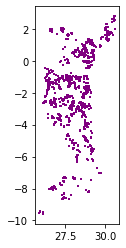

In [54]:
# Make a visualization with custom color and tick marks
mining_sites.plot(color='purple', marker='+', markersize=5)
plt.show()

Column Names:
WDPAID - WDPA_PID - PA_DEF - NAME - ORIG_NAME - DESIG - DESIG_ENG - DESIG_TYPE - IUCN_CAT - INT_CRIT
MARINE - REP_M_AREA - GIS_M_AREA - REP_AREA - GIS_AREA - NO_TAKE - NO_TK_AREA - STATUS - STATUS_YR - GOV_TYPE
OWN_TYPE - MANG_AUTH - MANG_PLAN - VERIF - METADATAID - SUB_LOC - PARENT_ISO - ISO3 - geometry

 National Parks Dataset 
                                        NAME                                         DESIG_ENG     DESIG_TYPE                                           geometry
0         Lyondji Bonobo Community Reserve           Classified Forest and Community Reserve       National  MULTIPOLYGON (((22.78361 0.18587, 22.78492 0.1...
1                Parc national des Virunga  Ramsar Site, Wetland of International Importance  International  MULTIPOLYGON (((29.11713 -1.64822, 29.11765 -1...
2                   Luo Scientific Reserve                                Scientific Reserve       National  MULTIPOLYGON (((22.56673 0.24907, 22.57264 0.2...
3               

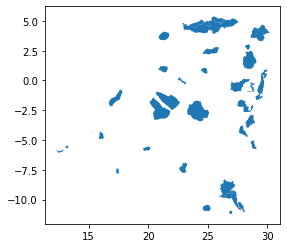

In [69]:
# Read the national parks site data
national_parks = geopandas.read_file('wdpamay2017cod-shapefile-polygons.geojson')

# Print column names from the dataframe
column_names = national_parks.columns
num_columns = len(column_names)
num_columns_per_row = 10
num_rows = -(-num_columns // num_columns_per_row)  # Ceiling division

print("Column Names:")
for i in range(num_rows):
    columns_row = column_names[i * num_columns_per_row : (i + 1) * num_columns_per_row]
    print(" - ".join(columns_row))
 
#subset the dataframe
national_parks = national_parks[['NAME', 'DESIG_ENG', 'DESIG_TYPE', 'geometry']]

# Print the first rows and the CRS information
print(f'\n National Parks Dataset \n  {national_parks.head(20)}')
print(f'\n The Coordinate Reference System (CRS) for the national parks dataset is: {national_parks.crs}')